# Data 422

Data Wrangling, S2 2019

## Assignement 2

Haoyang Chen

### Task (a): scrape data from websites


In this Assignment, We chose to scrape mobile phone sale data from the website of pbtech, a NZ computing and I.T. retailer.

In [ ]:
#load required libraries
library(tidyverse)
library(magrittr) # better handling of pipes
library(purrr) # to work with lists and map functions
library(glue) # to paste strings
library(stringr) # to hand strings
library(rvest) # web scraping library

In [ ]:
#the url of the mobile phone sale page
url_titles <- "https://www.pbtech.co.nz/category/phones-gps/smartphones/shop-all"
# read the url into r
page_name <- read_html(url_titles)

#extract the name of each mobile phone models
name_list <- page_name %>%
  html_nodes(".item_description .item_line_name") %>%
  html_attr("title")

#extract the url for the webpage of each phone
link_list <- page_name %>%
  html_nodes(".item_description .item_line_name") %>%
  html_attr("href")

#extract a list of mobile phone price
price_list <- page_name %>%
  html_nodes(".ginc .price_full ") %>%
  html_text()

# The function used to extract mobile phone brand and screen size
# The information is extracted from the sale page of each mobile phone
get_brand_screen <- function(link){
#Use glue to get the full url of each mobile phone page
  phone_page <- glue("https://www.pbtech.co.nz/{link}") %>%
  read_html()
  
  brand <- phone_page %>% 
  html_nodes(".infoContainer .p_codes_list_new .pblink") %>%
  html_text()
  
  screen_text <- phone_page %>% 
  html_nodes(xpath = '//*[@id="configurable_products_form"]/ul/li[1]') %>%
  html_text()
  brand_screen_list <- c(brand, screen_text)
  return(brand_screen_list)
}

# return a list of phone brand and screen size for each moblie phone from their detailed sale page.
Brand_screen_list <- map(link_list, get_brand_screen)

In [ ]:
#Let's check if we got the expected results
head(name_list)
head(link_list)
head(price_list)
head(Brand_screen_list)

[1] "Xiaomi Redmi Note 7 Dual SIM Smartphone 64GB Neptune Blue - Special Global Edition with Band 28 700MHz for full NZ mobile network compatibility"
[2] "Samsung Galaxy A10 (2019) Smartphone 32GB Black 2 Year Warranty"                                                                                
[3] "Xiaomi Mi 9T (K20) Dual SIM Smartphone 6GB+128GB Glacier Blue - Global Version - 2 Year Warranty"                                               
[4] "OPPO AX5 Dual SIM Smartphone 64GB - Diamond Blue 2 Years Warranty"                                                                              
[5] "Huawei Y5 2019 Smartphone 32GB - Amber Brown - 2 Year Warranty"                                                                                 
[6] "OnePlus 6T 8GB+128GB Dual SIM Smartphone - Mirror Black - Global Version - Oxygen OS. 2 Year Warranty. Parallel Imported."

[1] "product/MPHMIX017101/Xiaomi-Redmi-Note-7-Dual-SIM-Smartphone-64GB-Neptu"  
[2] "product/MPHSAM21000/Samsung-Galaxy-A10-2019-Smartphone-32GB-Black-2-Ye"   
[3] "product/MPHMIX039201/Xiaomi-Mi-9T-K20-Dual-SIM-Smartphone-6GB128GB-Glac"  
[4] "product/MPHOPP018510/OPPO-AX5-Dual-SIM-Smartphone-64GB---Diamond-Blue-2"  
[5] "product/MPHHUA71519020/Huawei-Y5-2019-Smartphone-32GB---Amber-Brown---2-Y"
[6] "product/MPHOPL061010I/OnePlus-6T-8GB128GB-Dual-SIM-Smartphone---Mirror-B"

[1] "$398.99" "$262.99" "$598.99" "$278.99" "$199.00" "$799.00"

[[1]]
[1] "Xiaomi"               "Screen Size:6 inches"

[[2]]
[1] "Samsung"                "Screen Size:6.2 inches"

[[3]]
[1] "Xiaomi"                  "Screen Size:6.39 inches"

[[4]]
[1] "OPPO"                   "Screen Size:6.2 inches"

[[5]]
[1] "Huawei"               "Screen Size:5 inches"

[[6]]
[1] "OnePlus"                "Screen Size:6.4 inches"

Our code works as expected. We successfully scrape the html into R.

### Task (b): wrangle it


Working on the page from task (a), transform the data you collected into relational data model.

In [ ]:
#The price list from take a is in messy format, we need to remove the dollar sign and the comma
#remove dollar sign
price_nosign <- regmatches(price_list,regexpr("(?<=\\$)(.*)",price_list, perl = TRUE))
#remove comma and convert it into numeric type
price_num <- sub(",","",price_nosign) %>% as.numeric()
head(price_num)

[1] 398.99 262.99 598.99 199.00 278.99 799.00

In [ ]:
# We need to seperate the brand and screen data from the Brand_screen_list
brand <- c()
screen <- c()
for (record in Brand_screen_list){
  brand <- c(brand,record[1])
  screen <- c(screen,record[2])
}

head(brand)
head(screen)

[1] "Xiaomi"  "Samsung" "Xiaomi"  "Huawei"  "OPPO"    "OnePlus"

[1] "Screen Size:6 inches"    "Screen Size:6.2 inches" 
[3] "Screen Size:6.39 inches" "Screen Size:5 inches"   
[5] "Screen Size:6.2 inches"  "Screen Size:6.4 inches"

In [ ]:
# We want the screen size data in numeric format not a line of text
#Frist use regular express to capture screen size in the middle of each records 
r <- regexpr("(?<=Screen Size:)(.*)(?= inches)",screen, perl = TRUE)
#set the screen size to -1 if data is NA
r <- replace(r, is.na(r), -1)
#create an empty container with NA
screen_num <- rep(NA, length(screen))
#fill the container with the screen size data
screen_num[r!=-1] <- regmatches(screen, r) %>% as.numeric()
head(screen_num)

[1] 6.00 6.20 6.39 5.00 6.20 6.40

In [ ]:
#Put all the data together into a dataframe
#We generated a dataframe with 5 columns
PB_df <- data.frame(Name = name_list, #name of the phone model
                    Link = link_list, #sale page url of each phone
                    Price = price_num, #price of phone in NZD
                    Brand = brand, 
                    Screen_size = screen_num) #screen size in inches
head(PB_df)

Name,Link,Price,Brand,Screen_size
<fct>,<fct>,<dbl>,<fct>,<dbl>
Xiaomi Redmi Note 7 Dual SIM Smartphone 64GB Neptune Blue - Special Global Edition with Band 28 700MHz for full NZ mobile network compatibility,product/MPHMIX017101/Xiaomi-Redmi-Note-7-Dual-SIM-Smartphone-64GB-Neptu,398.99,Xiaomi,6.00
Samsung Galaxy A10 (2019) Smartphone 32GB Black 2 Year Warranty,product/MPHSAM21000/Samsung-Galaxy-A10-2019-Smartphone-32GB-Black-2-Ye,262.99,Samsung,6.20
Xiaomi Mi 9T (K20) Dual SIM Smartphone 6GB+128GB Glacier Blue - Global Version - 2 Year Warranty,product/MPHMIX039201/Xiaomi-Mi-9T-K20-Dual-SIM-Smartphone-6GB128GB-Glac,598.99,Xiaomi,6.39
Huawei Y5 2019 Smartphone 32GB - Amber Brown - 2 Year Warranty,product/MPHHUA71519020/Huawei-Y5-2019-Smartphone-32GB---Amber-Brown---2-Y,199.00,Huawei,5.00
OPPO AX5 Dual SIM Smartphone 64GB - Diamond Blue 2 Years Warranty,product/MPHOPP018510/OPPO-AX5-Dual-SIM-Smartphone-64GB---Diamond-Blue-2,278.99,OPPO,6.20
OnePlus 6T 8GB+128GB Dual SIM Smartphone - Mirror Black - Global Version - Oxygen OS. 2 Year Warranty. Parallel Imported.,product/MPHOPL061010I/OnePlus-6T-8GB128GB-Dual-SIM-Smartphone---Mirror-B,799.00,OnePlus,6.40


### Task (c): automate it

Now it's the time to scrape everything else in the website. Turn your code for tasks (a) and (b) into a function and using `purrr` (and its `map_` functions, possibly in combination with `possibly`) apply that function to all the pages.

In [ ]:
#combine our code into a function
#They are multiple pages in the website, the page argument let you deside how many pages you want to scrape
get_phones <- function(page){
  
Name_link_price_list <- list()

for (pagination in 1:page){
  url_titles <- glue("https://www.pbtech.co.nz/category/phones-gps/smartphones/shop-all?pg={pagination}#sort_group_form")

  page_name <- read_html(url_titles)
  # the following code extract the name, link and price of each phone from the main page and combine them into a list
  name_list <- page_name %>%
  html_nodes(".item_description .item_line_name") %>%
  html_attr("title")
  
  link_list <- page_name %>%
  html_nodes(".item_description .item_line_name") %>%
  html_attr("href")
  
  price_list <- page_name %>%
  html_nodes(".ginc .price_full ") %>%
  html_text()
  
  Name_link_price_list <- c(Name_link_price_list,list(c(name_list, link_list, price_list)))
}

# seperate the name, link and price data
name <- c()
link <- c()
price <- c()
for (record in Name_link_price_list){
  name <- c(name,record[1:48])
  link <- c(link,record[49:96])
  price <- c(price,record[97:144])
}

#convert the price into clean format use regular expression as mentioned before
price_nosign <- regmatches(price,regexpr("(?<=\\$)(.*)",price, perl = TRUE))
price_num <- sub(",","",price_nosign) %>% as.numeric()

#use possibly function
get_brand_screen_safe <- purrr::possibly(.f = get_brand_screen,
                                   otherwise = list())
Brand_screen_list <- map(link, get_brand_screen_safe)

#seperate the brand and screen date from a list
brand <- c()
screen <- c()
for (record in Brand_screen_list){
  brand <- c(brand,record[1])
  screen <- c(screen,record[2])
}

#convert the screen size into clean format use regular expreesion as mentioned before
r <- regexpr("(?<=Screen Size:)(.*)(?= inches)",screen, perl = TRUE)
r <- replace(r, is.na(r), -1)
screen_num <- rep(NA, length(screen))
screen_num[r!=-1] <- regmatches(screen, r) %>% as.numeric()

#generate a dataframe with 5 columns
PB_df <- data.frame(Name = name,
                    Link = link,
                    Price = price_num,
                    Brand = brand,
                    Screen_size = screen_num)
return(PB_df)
}

In [ ]:
#Let's scrape 7 pages
PB_df <- get_phones(7)

In [ ]:
#Let's heck the dataframe we got
head(PB_df)
tail(PB_df)

Name,Link,Price,Brand,Screen_size
<fct>,<fct>,<dbl>,<fct>,<dbl>
Xiaomi Redmi Note 7 Dual SIM Smartphone 64GB Neptune Blue - Special Global Edition with Band 28 700MHz for full NZ mobile network compatibility,product/MPHMIX017101/Xiaomi-Redmi-Note-7-Dual-SIM-Smartphone-64GB-Neptu,398.99,Xiaomi,6.00
Samsung Galaxy A10 (2019) Smartphone 32GB Black 2 Year Warranty,product/MPHSAM21000/Samsung-Galaxy-A10-2019-Smartphone-32GB-Black-2-Ye,262.99,Samsung,6.20
Xiaomi Mi 9T (K20) Dual SIM Smartphone 6GB+128GB Glacier Blue - Global Version - 2 Year Warranty,product/MPHMIX039201/Xiaomi-Mi-9T-K20-Dual-SIM-Smartphone-6GB128GB-Glac,598.99,Xiaomi,6.39
OPPO AX5 Dual SIM Smartphone 64GB - Diamond Blue 2 Years Warranty,product/MPHOPP018510/OPPO-AX5-Dual-SIM-Smartphone-64GB---Diamond-Blue-2,278.99,OPPO,6.20
Huawei Y5 2019 Smartphone 32GB - Amber Brown - 2 Year Warranty,product/MPHHUA71519020/Huawei-Y5-2019-Smartphone-32GB---Amber-Brown---2-Y,199.00,Huawei,5.00
OnePlus 6T 8GB+128GB Dual SIM Smartphone - Mirror Black - Global Version - Oxygen OS. 2 Year Warranty. Parallel Imported.,product/MPHOPL061010I/OnePlus-6T-8GB128GB-Dual-SIM-Smartphone---Mirror-B,799.00,OnePlus,6.40


,Name,Link,Price,Brand,Screen_size
,<fct>,<fct>,<dbl>,<fct>,<dbl>
331,Samsung Galaxy S10+ SM-G975F Smartphone 8GB + 128GB Prism Black - 2 Year Warranty,product/MPHSAM197510/Samsung-Galaxy-S10-SM-G975F-Smartphone-8GB--128GB,1699.00,Samsung,6.4
332,Samsung Galaxy S9 SM-G960F Smartphone 64GB Lilac Purple 2 year warranty,product/MPHSAM296030/Samsung-Galaxy-S9-SM-G960F-Smartphone-64GB-Lilac-P?type=open,1363.99,Samsung,5.8
333,Samsung Galaxy S10e SM-G970F Smartphone 6GB + 128GB Prism Black - 2 Year Warranty,product/MPHSAM297010/Samsung-Galaxy-S10e-SM-G970F-Smartphone-6GB--128GB,1298.99,Samsung,5.8
334,Samsung Galaxy S10+ SM-G975F Smartphone 8GB + 512GB Ceramic White - 2 Year Warranty,product/MPHSAM297540/Samsung-Galaxy-S10-SM-G975F-Smartphone-8GB--512GB,2098.99,Samsung,6.4
335,Apple iPhone 8 256GB Space Grey,product/MPHAPP1842560/Apple-iPhone-8-256GB-Space-Grey,1399.00,Apple,4.7
336,Apple iPhone 8 256GB Silver,product/MPHAPP1842561/Apple-iPhone-8-256GB-Silver,1399.00,Apple,4.7


Now we have a data frame with 5 columns and 336 rows (information of 336 mobile phones).

### Task (d): plot it

Use graphics (via `ggplot`) to represent the data you collected in a meaningful way.

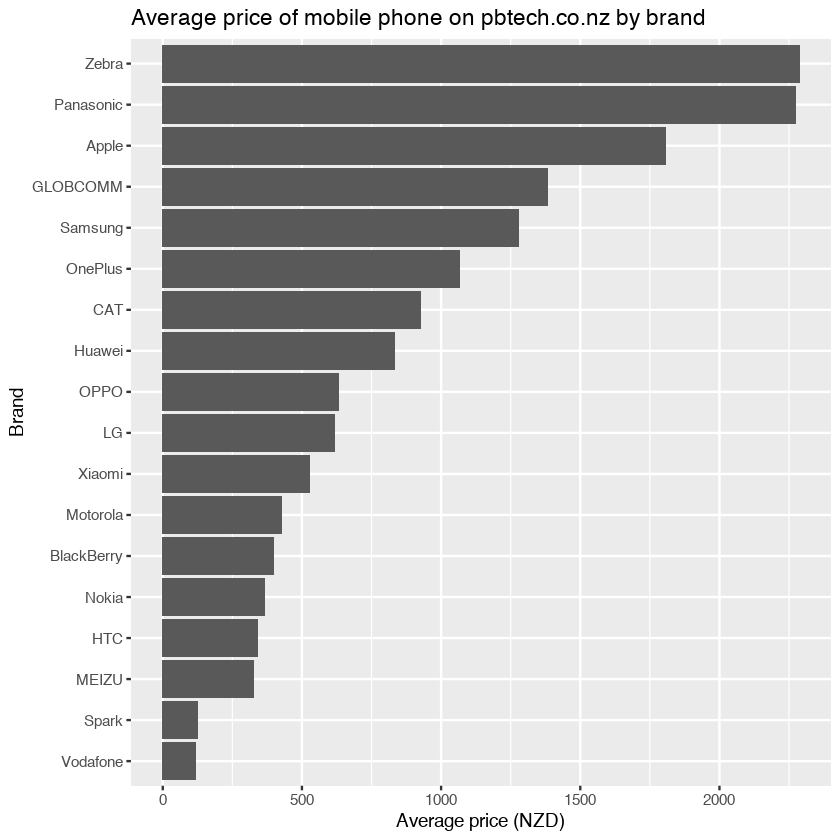

In [ ]:
#prepare the data for the first plot
price_brand_df <- aggregate(Price ~ Brand, PB_df, mean) #calculate the average price of each brand
price_brand_df <- price_brand_df[order(price_brand_df$Price),] # reorder it
price_brand_df$Brand <- factor(price_brand_df$Brand, levels=price_brand_df$Brand) # covert the brand format to factor

#plot a bar chart showing the average price of each brand
library(ggplot2)
ggplot(price_brand_df[3:20,],aes(x=Brand,y=Price))+geom_bar(stat = "identity")+
  labs(title = "Average price of mobile phone on pbtech.co.nz by brand", y="Average price (NZD)") +
  coord_flip()

In [ ]:
#prepare the data for the second plot
brand_df<-aggregate(data.frame(Count = PB_df[,"Brand"]),
          by = list(Brand = PB_df[,"Brand"]), FUN = length) #count the number of phones for each brand
brand_df[,"Brand"] %<>% as.character()
#if a brand has less than 10 type of phones, we rename it as Other
for (n in 1:nrow(brand_df)){
  if (brand_df[n,2]<10){
    brand_df[n,1] <- "Other"}
}
# recalculate the sum of each brand
brand_df <- aggregate(brand_df["Count"],by=brand_df["Brand"],sum)
#reorder the dataframe to decreasing order
brand_df<- brand_df[order(brand_df$Count,decreasing = TRUE),]
#convert brand column to factor format
brand_df$Brand <- factor(brand_df$Brand, levels=brand_df$Brand)

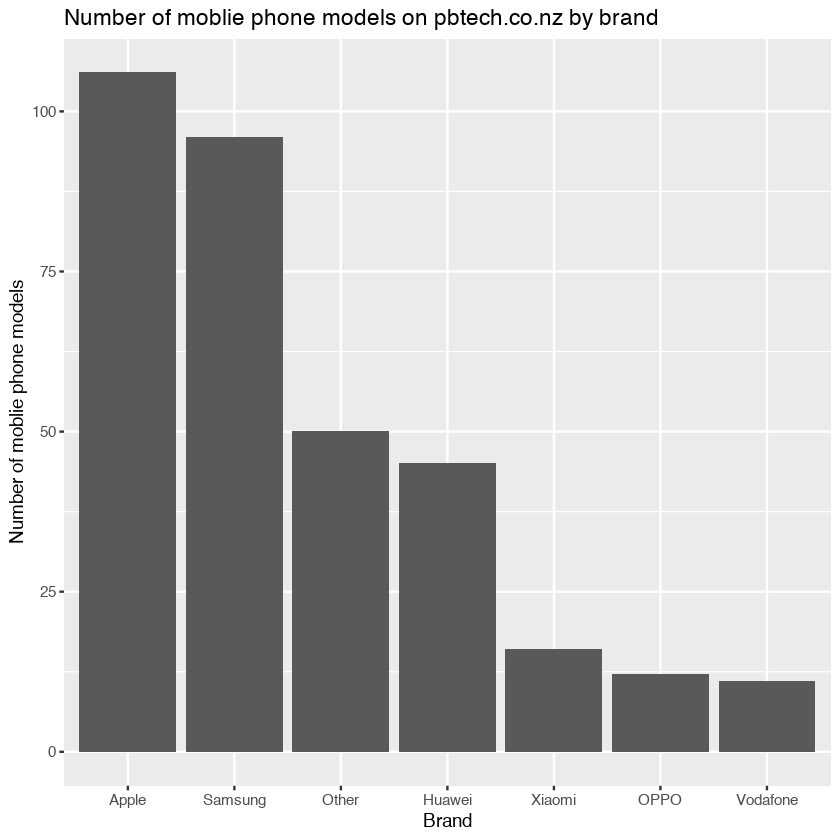

In [ ]:
#plot a bar chart showing the number of mobile phone models by brand
ggplot(brand_df, aes(x=Brand, y=Count))+
  geom_bar(stat = "identity")+
  labs(title = "Number of moblie phone models on pbtech.co.nz by brand", y="Number of moblie phone models")

In [ ]:
#prepare the data for the third plot
#we only need three columns this time
plot_df = PB_df[!is.na(PB_df$Screen_size),c("Screen_size","Brand","Price")]
plot_df[,"Brand"] %<>% as.character()
#rename the brand name to Other if it is not one of the top 6 brand we got from the last plot
for (n in 1:nrow(plot_df)){
  if (not(plot_df[n,"Brand"] %in% c("Apple","Samsumg","Huawei","OPPO","Vodafone","Xiaomi"))){
    plot_df[n,"Brand"] = "Other"}
}

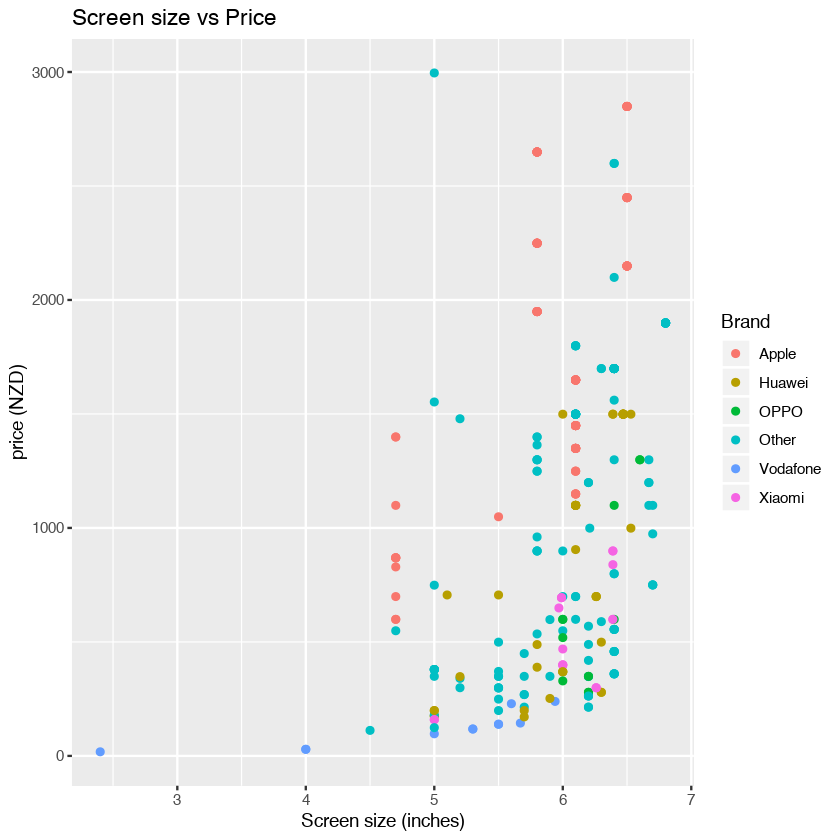

In [ ]:
#plot a scatter plot showing the screen size vs price.
ggplot(plot_df,aes(x=Screen_size, y=Price, color=Brand)) +
  geom_point()+
  labs(title="Screen size vs Price", x="Screen size (inches)", y= "price (NZD)")

Conclusion:

The first graph shows that mobile phone price range from around 100 NZD to around 2500 NZD. Apple is the most expensive brand among popular brands.

The second graph shows that Apple and Samsung have the most number of mobile phone models.

The third graph shows that a phone with a larger screen usually has a higher price. The screen size of most phone models is around 6 inches. Apple has a unique pattern compared with other phones. It is the most expensive phone in the market when compared with phones from other brands with similar screen size.

### Task (e): APIs

In this task, I collected the daily pageview counts of one specific Wikipedia article, convert the JSON data into dataframe and then plot it. I have referenced this page for wikipedia API introduction: https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews

In [ ]:
library(rlist)
library(httr)
starting <- "20151001"
ending <- "20191001"
article_title <- "SpaceX"
#replace the url with our timestamps and article name.
url <- paste("https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents",
             article_title,
             "daily",
             starting,
             ending,
             sep = "/")
response <-GET(url)
#use the GET funtion from httr package to get the data

timestamp,views
<date>,<int>
2015-10-01,3355
2015-10-02,3019
2015-10-03,2807
2015-10-04,3031
2015-10-05,3557
2015-10-06,3881


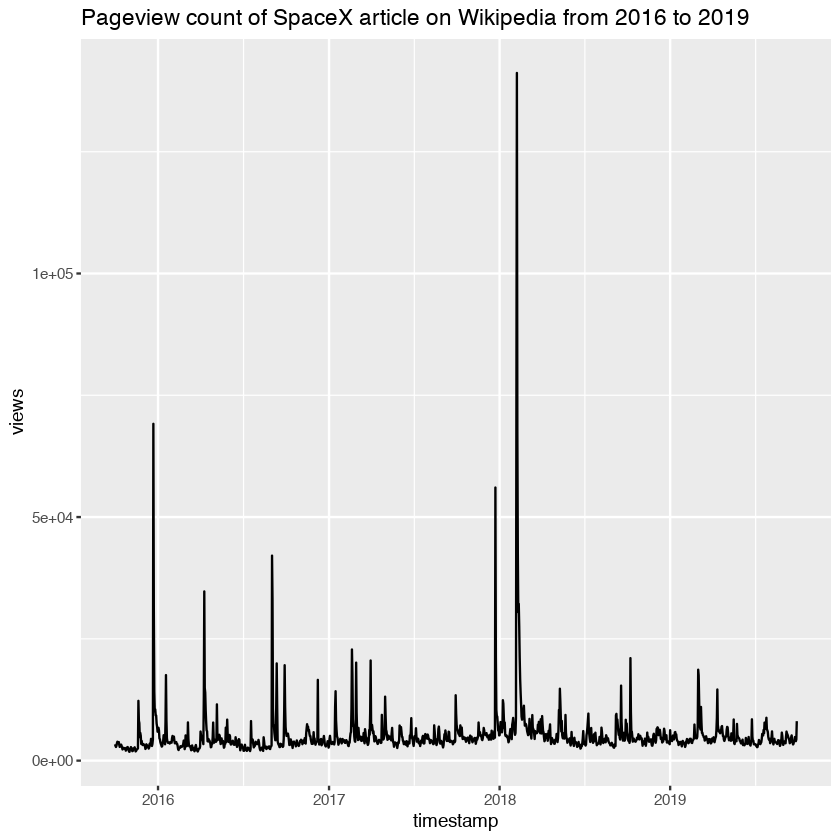

In [ ]:
library(jsonlite)
#use jsonlite library to extract informatio from JSON file
result <- fromJSON(content(response, as="text"))
df <- list.stack(list.select(result, timestamp, views)) #select the columns we need
library(lubridate)
df$timestamp <- ymd(str_sub(df$timestamp, 1, -3)) 
#use str_sub to remove the last 2 digit in the timestamps because they are timezone information which we don't need
# and then convert the timestamps to ymd data format
head(df)
ggplot(data=df, aes(timestamp, views)) + 
  geom_line() +
  labs(title="Pageview count of SpaceX article on Wikipedia from 2016 to 2019") # plot a line graph

There is a spike around Feb 2018, that is probably because of the frist Falcon Heavy launch.